In [1]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [2]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from straightLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [4]:
dataMachine = data_handler.DataHandler()

In [5]:
img, label = dataMachine.augmentEpoch(30)

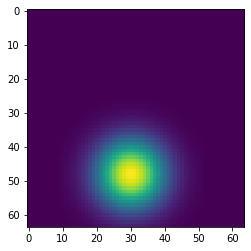

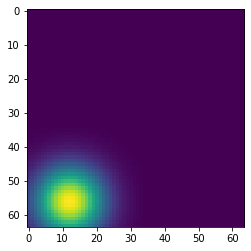

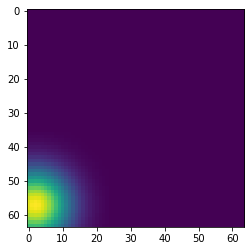

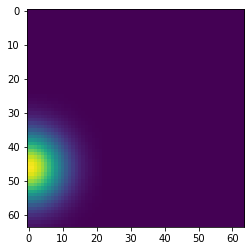

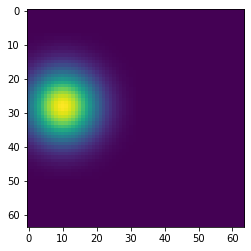

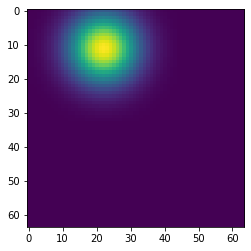

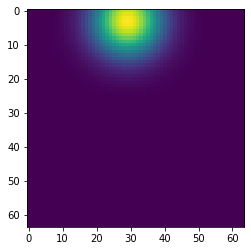

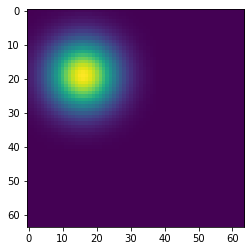

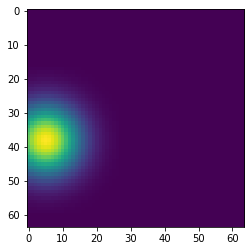

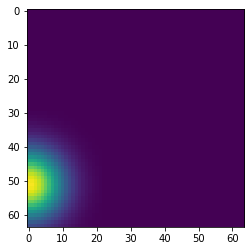

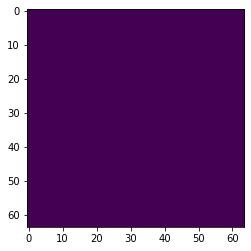

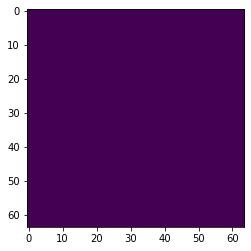

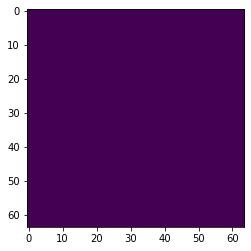

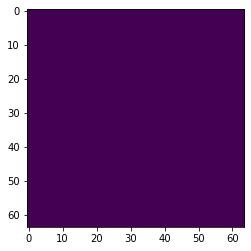

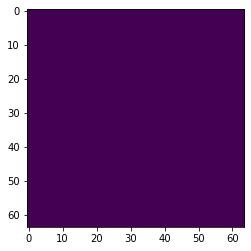

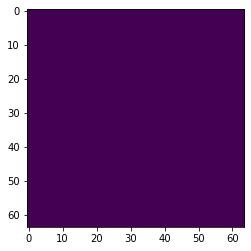

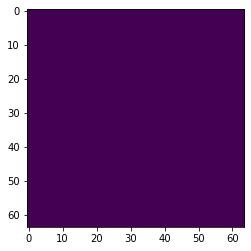

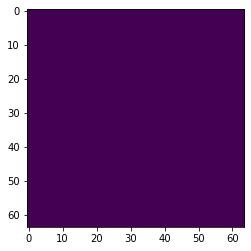

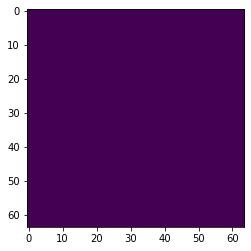

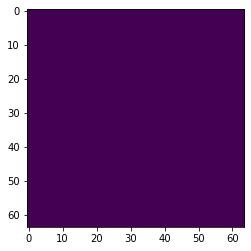

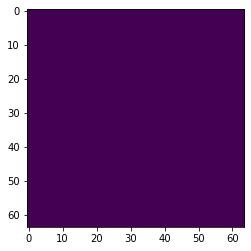

In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()

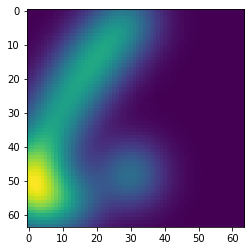

In [7]:
plt.imshow(np.sum(label[1],axis=0))

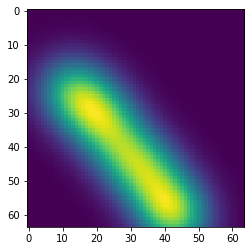

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [9]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [10]:
tf.config.run_functions_eagerly(False)

In [11]:
model = create_hourglass_network(7, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [12]:
model.compile(optimizer="Adam", loss=loss_func)

In [16]:
data = dataMachine.augmentEpoch(30)
np.shape(data[1])

(30, 21, 64, 64)

In [17]:
model.fit(data[0], data[1], batch_size=1,epochs=2)

Epoch 1/2
Tensor("Mean:0", shape=(), dtype=float32)


2024-08-22 03:14:18.823771: W tensorflow/core/kernels/conv_ops_gpu.cc:321] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1
in_depths: 256
out_depths: 7
in: 64
in: 64
data_format: 1
filter: 1
filter: 1
filter: 256
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_FLOAT
group_count: 1
device_identifier: "sm_8.0 with 42298834944B RAM, 108 cores, 1410000KHz clock, 1215000KHz mem clock, 41943040B L2$"
version: 3

2024-08-22 03:14:18.824301: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at conv_grad_input_ops.cc:385 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng25{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while

NotFoundError: Graph execution error:

Detected at node 'gradient_tape/model/3_conv_1x1_parts/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1077, in launch_instance
      app.start()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/ubuntu/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_107258/2542992605.py", line 1, in <module>
      model.fit(data[0], data[1], batch_size=1,epochs=2)
    File "/usr/lib/python3/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/usr/lib/python3/dist-packages/keras/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/usr/lib/python3/dist-packages/keras/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/3_conv_1x1_parts/Conv2D/Conv2DBackpropInput'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng25{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng4{k11=2}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 77576192 bytes.
  Profiling failure on CUDNN engine eng2{k2=1,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng2{k2=0,k3=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node gradient_tape/model/3_conv_1x1_parts/Conv2D/Conv2DBackpropInput}}]] [Op:__inference_train_function_98531]

In [ ]:
out = model.predict(data[0])

In [ ]:
np.shape(out)

In [ ]:
np.sum(np.transpose(out[3][0],(2,0,1)),axis=0)

0.087227404


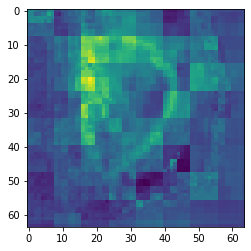

0.08366412


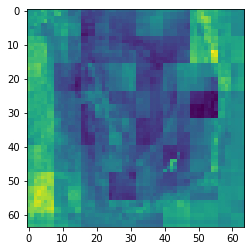

0.07733818


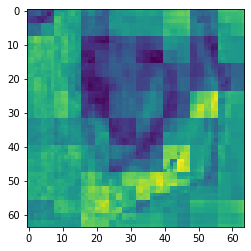

0.0788677


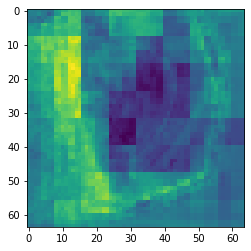

0.035214044


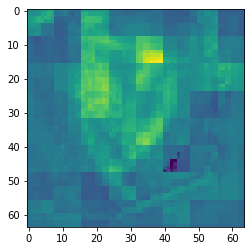

0.07365183


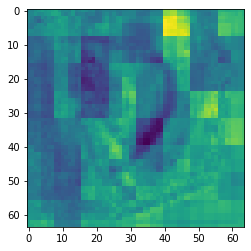

0.09617882


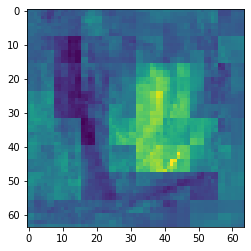

In [18]:
for x in np.transpose(out[0][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

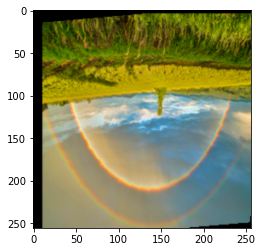

In [50]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


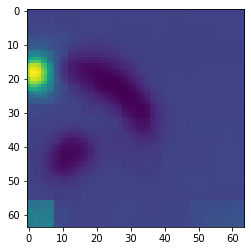

0.004737408


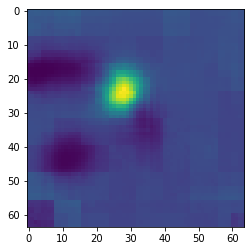

0.015574261


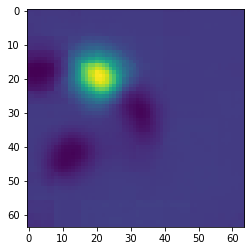

0.011428473


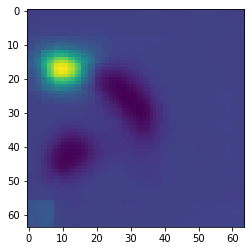

0.0055831005


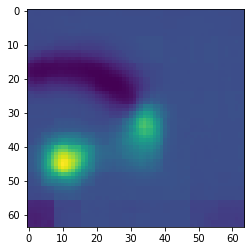

0.0073060193


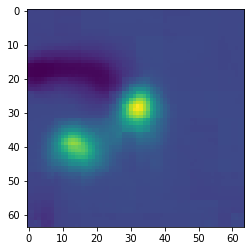

0.003621494


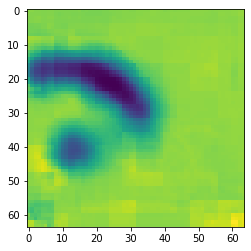

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


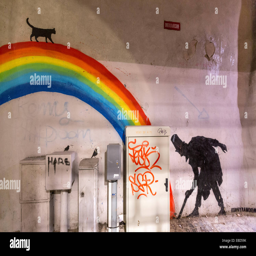

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

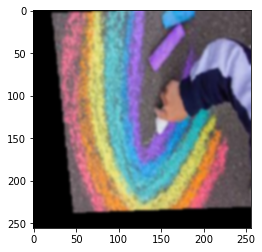

In [5]:
plt.imshow(img[1]/255.0)

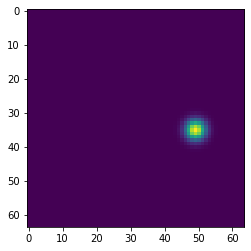

0


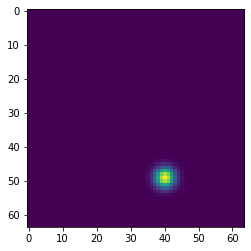

1


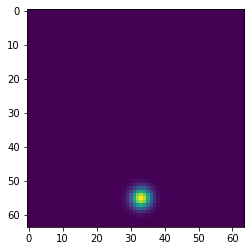

2


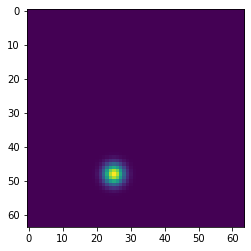

3


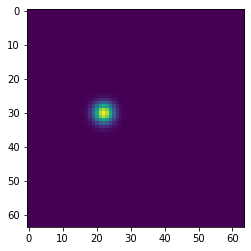

4


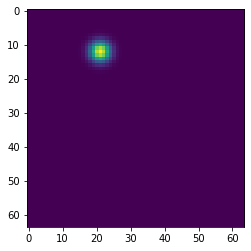

5


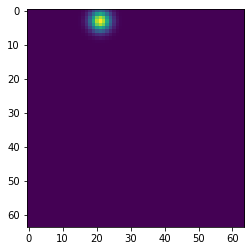

6


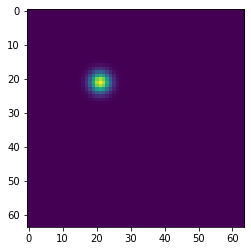

7


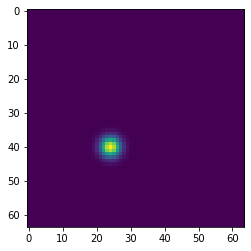

8


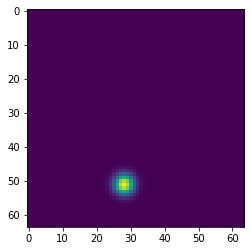

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

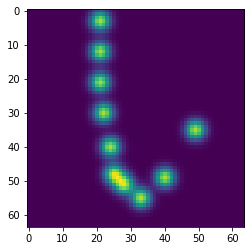

In [7]:
plt.imshow(np.sum(label[1],axis=0))

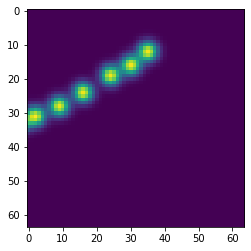

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

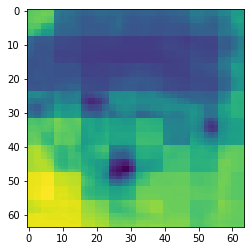

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


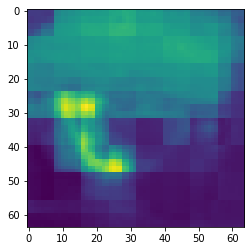

0.018625474


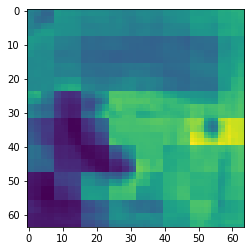

0.003564904


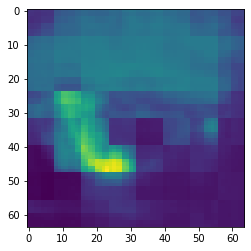

0.00058319094


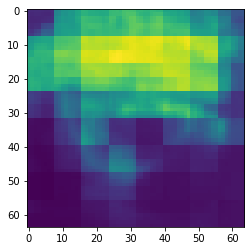

0.0023697943


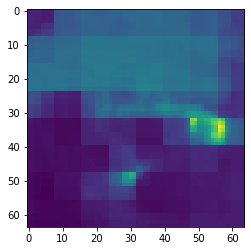

0.031174866


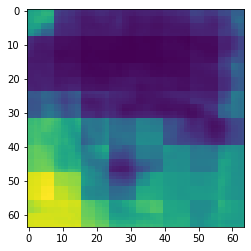

0.0022596146


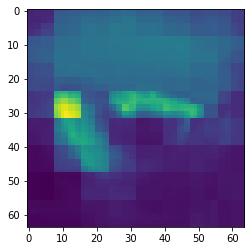

0.005172058


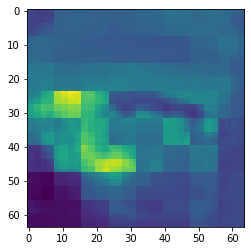

0.0013132769


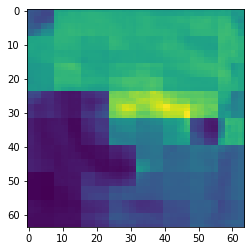

0.0035540778


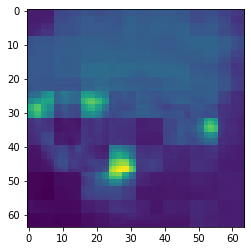

0.0017217919


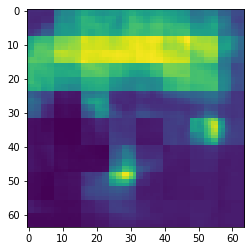

0.0019383262


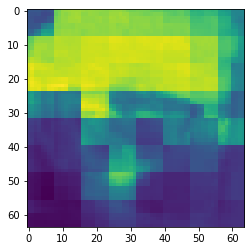

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

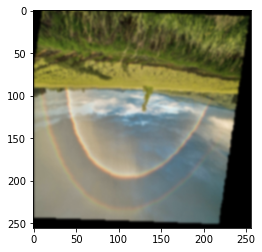

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


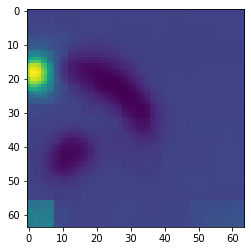

0.004737408


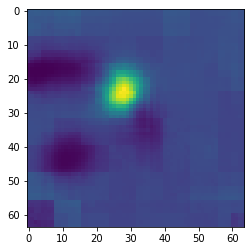

0.015574261


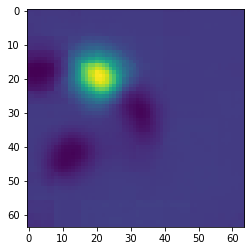

0.011428473


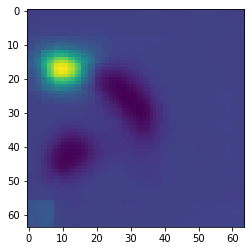

0.0055831005


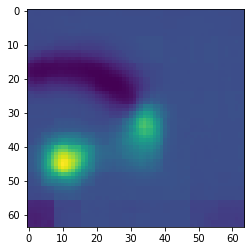

0.0073060193


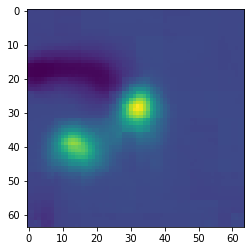

0.003621494


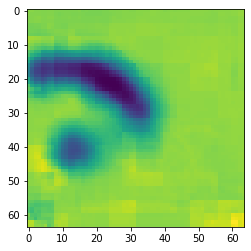

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


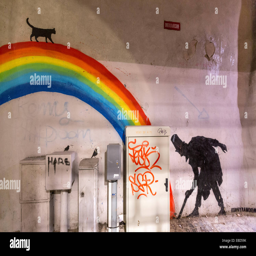

In [110]:
gah

In [ ]:
model.summary()